<div style="text-align: center; color: Green; font-size: 24px;">
  <strong> Prédiction du revenu annuel d’un marocain</strong><br>
  Realise par Mohamed Sadki, Kaoutar Iabakriman et Nada El Mourabet - GI2 2025
</div>


# Prédiction du revenu annuel d’un marocain
L’objectif général de ce mini-projet est de **construire un pipeline complet** de Machine
Learning en Python pour prédire le revenu annuel des Marocains à partir de données
simulées réalistes.
Le projet couvre toutes les étapes de développement d’un modèle de de Machine
Learning à savoir : compréhension des données, préparation des données, modélisation,
évaluation et déploiement.

# Etape 1: Compréhension des données
## Chargement du Dataset
Afin de commencer notre projet, on a cree un script python pour generer un Dataset contenant **40000 enregistrements**, Le revenu annuel varie en fonction de plusieurs facteurs, en particulier :  
- **Âge** : le revenu a tendance d’augmenter lorsqu’on se rapproche de l’âge de
retraite.
- **Catégorie d’âge** : jeune, adulte, sénior et âgé
- **Urbain/Rural** : les personnes issues du milieu urbain ont tendance à gagner
plus que les personnes du milieu rural.  
- **Sexe** : le revenu moyen des hommes est plus élevé que celui des femmes.
- **niveau d'éducation** : (quatre niveaux à distinguer : sans niveau, fondamental,
secondaire, supérieur), avec un revenu moyen plus élevé pour les personnes
ayant un niveau d’enseignement supérieur.
- **Années d’expérience** : Plus on est expérimenté, plus le revenu est élevé.
- **État matrimonial** : Célibataire, marié, divorcé, veuf, divorcé
- **Possession de biens** : (voiture, logement, terrain, etc.) ça peut refléter le
niveau socio-économique d’un citoyen.
- **Catégorie socioprofessionnelle** : on peut distinguer 6 grands groupes (classés
du plus haut revenu au plus bas) :
    - Groupe 1 : est celui des responsables hiérarchiques de la fonction
    publique, directeurs et cadres de direction d'entreprises, cadres
    supérieurs et membres des professions libérales
    - Groupe 2 : englobe les cadres moyens, des employés et des
    commerçants et intermédiaires commerciaux et financiers  
    - Groupe 3 : comprend les inactifs (retraités, rentiers, et autres inactifs)
    - Groupe 4 : est celui des exploitants agricoles, pêcheurs, forestiers,
    chasseurs et travailleurs assimilés et les ouvriers agricoles
    - Groupe 5 : comporte les conducteurs d'installations et de machines, les
    artisans et les ouvriers qualifiés
    - Groupe 6 : inclue les manœuvres non agricoles, les manutentionnaires
    et travailleurs des petits métiers et les chômeurs n'ayant jamais
    travaillé.
- **Nombre des enfants**: Nombre total d’enfants (biologiques ou adoptés), parfois distingués par ceux à charge.
- **Education numero**: Identifiant scolaire ou code correspondant au niveau d’éducation atteint.
- **Date de naissance**: Jour, mois et année de naissance, format JJ/MM/AAAA.
- **Region**: Zone géographique ou administrative de résidence ou d’origine.
- **Secteur d'emploi**: Domaine professionnel ou industrie où la personne travaille (ex : santé, éducation, technologie).

In [2]:
# Importation des Bibliothèques
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

<div class="alert alert-info">
<p style="font-weight: bold;">Note</p>
Le dataset inclure également :
    
- **Valeurs manquantes**: faraghat di dataset  
- **Valeurs aberrantes**: Salaire negative, Sexe Autre
- **Colonnes redondantes**: Education numero, Date de naissance
- **Colonnes non pertinentes**: Groupe Sangaine, Color preferee
</div>

In [3]:
from datetime import datetime

def generate_dataset(n_samples=40000, random_state=42):
    """Generate synthetic Moroccan income dataset with exactly n_samples including duplicates"""

    np.random.seed(random_state)

    # Calculate how many unique rows we need (to get n_samples after duplication)
    unique_rows = int(n_samples * 0.93)  # 93% unique = 7% duplicates
    duplicate_count = n_samples - unique_rows

    # 1. Age calculation
    def random_birth_date(n):
        return [datetime(np.random.randint(1962, 2009),
                np.random.randint(1, 13),
                np.random.randint(1, 29)) for _ in range(n)]

    dates_naissance = random_birth_date(unique_rows)
    ages_annees = [(datetime.now() - dn).days // 365 for dn in dates_naissance]

    # 2. Age categories with 5% outliers
    age_categories = np.select(
        [np.array(ages_annees) < 25,
         (np.array(ages_annees) >= 25) & (np.array(ages_annees) < 40),
         (np.array(ages_annees) >= 40) & (np.array(ages_annees) < 60),
         np.array(ages_annees) >= 60],
        ["Jeune", "Adulte", "Senior", "Âgé"],
        default="Adulte"
    )

    # Introduce 5% outliers in age categories
    outlier_indices = np.random.choice(unique_rows, size=int(unique_rows*0.05), replace=False)
    for idx in outlier_indices:
        age = ages_annees[idx]
        if age < 25:
            # Young person assigned to wrong category
            age_categories[idx] = np.random.choice(["Adulte", "Senior", "Âgé"])
        elif age >= 60:
            # Elderly person assigned to wrong category
            age_categories[idx] = np.random.choice(["Jeune", "Adulte", "Senior"])
        else:
            # Adult/Senior assigned to wrong category
            age_categories[idx] = np.random.choice(["Jeune", "Adulte", "Senior", "Âgé"])
            while (age < 25 and age_categories[idx] != "Jeune") or \
                  (25 <= age < 45 and age_categories[idx] != "Adulte") or \
                  (45 <= age < 63 and age_categories[idx] != "Senior") or \
                  (age >= 63 and age_categories[idx] != "Âgé"):
                age_categories[idx] = np.random.choice(["Jeune", "Adulte", "Senior", "Âgé"])
                
    visa_Schengen = np.random.choice([False, True], unique_rows, p=[0.85, 0.15])  # 15% de la population a un visa

    # 3. Geographic features
    regions = ['Casablanca_Settat', 'Rabat_Salé_Kénitra', 'Marrakech_Safi',
               'Fès_Meknès', 'Tanger_Tétouan_Al_Hoceïma', 'Oriental',
               'Béni_Mellal_Khénifra', 'Souss_Massa', 'Guelmim_Oued_Noun',
               'Laâyoune_Sakia_El_Hamra', 'Dakhla_Oued_Ed_Dahab', 'Drâa_Tafilalet']
    region = np.random.choice(regions, unique_rows)
    milieu = np.random.choice(["Urbain", "Rural"], unique_rows, p=[0.6, 0.4])
    sexe = np.random.choice(["Homme", "Femme", "Autre"], unique_rows, p=[0.50, 0.45, 0.05])

    # 4. Education
    education = np.random.choice(
        ["Sans niveau", "Fondamental", "Secondaire", "Supérieur"],
        unique_rows,
        p=[0.15, 0.35, 0.35, 0.15]
    )
    education_code = np.select(
        [education == "Sans niveau", education == "Fondamental",
         education == "Secondaire", education == "Supérieur"],
        [0, 1, 2, 3],
        default=-1
    )

    # 5. Experience
    experience = np.round(np.clip(np.array(ages_annees) - 18 - np.random.randint(0, 5, unique_rows), 0, None)).astype(int)

    # 6. Employment sector
    secteur_emploi = np.random.choice(
        ['Agriculture', 'Industrie', 'Services', 'Public', 'Privé', 'Chômeur'],
        unique_rows,
        p=[0.2, 0.15, 0.3, 0.15, 0.15, 0.05]
    )

    # 7. Marital status
    statut_matrimonial = np.random.choice(
        ["Célibataire", "Marié(e)", "Divorcé(e)", "Veuf(ve)"],
        unique_rows,
        p=[0.15, 0.55, 0.20, 0.10]
    )

    # 8. Possessions

    possede_voiture = np.array([np.random.choice([True, False], p=[0.4, 0.6]) if m == "Urbain"
                              else np.random.choice([True, False], p=[0.2, 0.8]) for m in milieu], dtype=bool)
    possede_maison = np.array([np.random.choice([True, False], p=[0.5, 0.5]) if m == "Urbain"
                             else np.random.choice([True, False], p=[0.7, 0.3]) for m in milieu], dtype=bool)

    # 9. Socio-professional categories
    categorie_socio = np.random.choice([1, 2, 3, 4, 5, 6], unique_rows, p=[0.05, 0.10, 0.15, 0.3, 0.25, 0.15])

    # Base income by category
    base_incomes = {
        1: np.random.normal(400000, 10000, unique_rows),
        2: np.random.normal(255000, 8000, unique_rows),
        3: np.random.normal(165000, 6000, unique_rows),
        4: np.random.normal(90000, 5000, unique_rows),
        5: np.random.normal(64000, 4000, unique_rows),
        6: np.random.normal(30000, 3000, unique_rows)
    }
    revenu_de_base = np.array([base_incomes[c][i] for i, c in enumerate(categorie_socio)])

    # New income calculation with adjustments
    education_multiplier = np.select(
        [education == "Sans niveau", education == "Fondamental",
         education == "Secondaire", education == "Supérieur"],
        [0.7, 0.9, 1.2, 1.8],
        default=1
    )
    sex_adjustment = np.select(
        [sexe == "Homme", sexe == "Femme", sexe == "Autre"],
         [1.25, 0.85, 0.60],  # Nouveaux multiplicateurs pour obtenir 55%/35%/10%
        default=1
    )

    # Calculate initial income with all factors
    revenu = revenu_de_base * education_multiplier * sex_adjustment + (experience * 250)

    # AJOUT DES NOUVELLES CONTRAINTES
    # 1. Augmentation du revenu avec l'âge (approche retraite)
    age_multiplier = 1 + (np.array(ages_annees) / 100)  # +1% par année

    # 2. Bonus pour les 63+ ans
    age_bonus = np.where(np.array(ages_annees) >= 63, 1.15, 1.0)

    # 3. Bonus pour le groupe socio-professionnel 3
    csp_bonus = np.where(np.array(categorie_socio) == 3, 1.1, 1.0)

    # Appliquer les nouveaux multiplicateurs
    revenu = revenu * age_multiplier * age_bonus * csp_bonus

    # Adjust to match urban/rural targets
    urban_mean = 26988
    rural_mean = 12862

    # Calculate current means
    current_urban_mean = np.mean(revenu[milieu == "Urbain"])
    current_rural_mean = np.mean(revenu[milieu == "Rural"])

    # Apply scaling to match target means
    revenu = np.where(
        milieu == "Urbain",
        revenu * (urban_mean / current_urban_mean),
        revenu * (rural_mean / current_rural_mean)
    )
    revenu = np.where(visa_Schengen, 
                 revenu * 1.35,  # +35% de revenu pour ceux avec visa
                 revenu)
    # Round to 2 decimal places
    revenu = np.round(revenu, 2)

    # Other features
    nombre_enfants = np.random.poisson(1.5, unique_rows)
    groupe_sanguin = np.random.choice(["A+", "A-", "B+", "B-", "AB+", "AB-", "O+", "O-"], unique_rows)
    couleur_preferee = np.random.choice(["Rouge", "Bleu", "Vert", "Jaune", "Noir", "Blanc"], unique_rows)

    # Create initial DataFrame
    df = pd.DataFrame({
        "date_naissance": [d.strftime("%Y-%m-%d") for d in dates_naissance],
        "age": ages_annees,
        "categorie_age": age_categories,  # Added age category
        "region": region,
        "milieu": milieu,
        "sexe": sexe,
        "niveau_education": education,
        "niveau_education_code": education_code,
        "annees_experience": experience,
        "secteur_emploi": secteur_emploi,
        "statut_matrimonial": statut_matrimonial,
        "possede_voiture": possede_voiture,
        "possede_maison": possede_maison,
        "categorie_socio": categorie_socio,
        "nombre_enfants": nombre_enfants,
        "groupe_sanguin": groupe_sanguin,
        "couleur_preferee": couleur_preferee,
        "visa_Schengen": visa_Schengen,
        "revenu_annuel_DH": revenu
    })

    # Add missing values
    missing_rates = {
        "niveau_education": 0.05,
        "niveau_education_code": 0.05,
        "annees_experience": 0.07,
        "statut_matrimonial": 0.03,
        "possede_voiture": 0.05,
        "categorie_socio": 0.06,
        "nombre_enfants": 0.08,
        "region": 0.10,
        "secteur_emploi": 0.07
    }
    for col, rate in missing_rates.items():
        df.loc[df.sample(frac=rate, random_state=random_state).index, col] = np.nan

    # Add duplicates (select random rows to duplicate)
    dupes_to_add = df.sample(n=duplicate_count, random_state=random_state)
    df = pd.concat([df, dupes_to_add], ignore_index=True)

    # Verify we have exactly n_samples
    df = df.iloc[:n_samples]

    return df

if __name__ == "__main__":
    data = generate_dataset(40000)

    # Calculate statistics
    print(f"Total rows: {len(data)}")
    print(f"Duplicate rows: {len(data[data.duplicated()])}")
    print(f"\nOverall mean income: {data['revenu_annuel_DH'].mean():.2f} DH")
    print(f"Urban mean income: {data[data['milieu'] == 'Urbain']['revenu_annuel_DH'].mean():.2f} DH")
    print(f"Rural mean income: {data[data['milieu'] == 'Rural']['revenu_annuel_DH'].mean():.2f} DH")

    # Verify age categories and outliers
    age_cat_stats = data.groupby('categorie_age')['age'].agg(['count', 'min', 'max', 'mean'])
    print("\nAge Category Statistics:")
    print(age_cat_stats)

    # Check outliers (people with wrong age category)
    print("\nSample of age category outliers:")
    outliers = data[
        ((data['age'] < 25) & (data['categorie_age'] != "Jeune")) |
        ((data['age'] >= 25) & (data['age'] < 40) & (data['categorie_age'] != "Adulte")) |
        ((data['age'] >= 40) & (data['age'] < 60) & (data['categorie_age'] != "Senior")) |
        ((data['age'] >= 60) & (data['categorie_age'] != "Âgé"))
    ]
    print(outliers[['age', 'categorie_age']].sample(10))

    # Vérification des nouvelles contraintes
    print("\nVérification des nouvelles contraintes:")
    print("1. Revenu moyen par groupe d'âge:")
    print(data.groupby('categorie_age')['revenu_annuel_DH'].mean().sort_values(ascending=False))

    print("\n2. Revenu moyen pour les 63+ ans vs autres:")
    print(f"63+ ans: {data[data['age'] >= 63]['revenu_annuel_DH'].mean():.2f} DH")
    print(f"Autres: {data[data['age'] < 63]['revenu_annuel_DH'].mean():.2f} DH")

    print("\n3. Revenu moyen pour le groupe socio-professionnel 3:")
    print(f"CSP 3: {data[data['categorie_socio'] == 3]['revenu_annuel_DH'].mean():.2f} DH")
    print(f"Autres CSP: {data[data['categorie_socio'] != 3]['revenu_annuel_DH'].mean():.2f} DH")

    print("\nSample data:")
    print(data.head())

    data.to_csv("dataset_revenu_marocains.csv", index=False)
    print("\nDataset saved to CSV")

C:\Users\Kaoutar Iabakriman\AppData\Local\Temp\ipykernel_10904\1847195761.py:202: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.sample(frac=rate, random_state=random_state).index, col] = np.nan


Total rows: 40000
Duplicate rows: 2800

Overall mean income: 22500.57 DH
Urban mean income: 28532.75 DH
Rural mean income: 13532.91 DH

Age Category Statistics:
               count  min  max       mean
categorie_age                            
Adulte         13210   16   63  32.124830
Jeune           6981   16   63  20.459103
Senior         16957   16   63  49.290087
Âgé             2852   16   63  59.529453

Sample of age category outliers:
       age categorie_age
8324    18        Adulte
1969    41        Adulte
23963   21           Âgé
1927    40        Adulte
35582   19        Senior
24487   61        Senior
29213   40        Adulte
32379   17           Âgé
2401    44        Adulte
12059   22        Senior

Vérification des nouvelles contraintes:
1. Revenu moyen par groupe d'âge:
categorie_age
Âgé       27218.274677
Senior    24624.307695
Adulte    20915.119917
Jeune     18414.696840
Name: revenu_annuel_DH, dtype: float64

2. Revenu moyen pour les 63+ ans vs autres:
63+ ans: 3333

## Affichage des données
On fait apparaitre les 10 premières instances du dataset.

In [5]:
df = pd.read_csv('dataset_revenu_marocains.csv')
df.head(10)

date_naissance  age categorie_age                   region  milieu   sexe  \
0     2000-04-15   25        Adulte       Rabat_Salé_Kénitra  Urbain  Femme   
1     2004-08-21   20         Jeune               Fès_Meknès  Urbain  Homme   
2     2000-10-19   24         Jeune        Guelmim_Oued_Noun   Rural  Homme   
3     1984-11-11   40        Senior  Laâyoune_Sakia_El_Hamra  Urbain  Femme   
4     1985-05-04   40        Senior                      NaN  Urbain  Homme   
5     2001-08-03   23         Jeune           Drâa_Tafilalet   Rural  Femme   
6     1983-05-02   42        Senior              Souss_Massa  Urbain  Femme   
7     1985-12-06   39        Adulte        Casablanca_Settat  Urbain  Homme   
8     1963-12-21   61           Âgé     Dakhla_Oued_Ed_Dahab  Urbain  Femme   
9     1994-12-26   30        Adulte                 Oriental  Urbain  Femme   

  niveau_education  niveau_education_code  annees_experience secteur_emploi  \
0       Secondaire                    2.0                3.0    Agriculture   
1      Sans niveau                    0.0                0.0       Services   
2      Sans niveau                    0.0                6.0         Public   
3        Supérieur                    3.0               19.0        Chômeur   
4              NaN                    NaN                NaN            NaN   
5       Secondaire                    2.0                3.0      Industrie   
6        Supérieur                    3.0               24.0          Privé   
7       Secondaire                    2.0               18.0      Industrie   
8       Secondaire                    2.0               43.0          Privé   
9        Supérieur                    3.0                9.0       Services   

  statut_matrimonial possede_voiture  possede_maison  categorie_socio  \
0         Divorcé(e)            True           False              3.0   
1        Célibataire            True           False              4.0   
2           Marié(e)           False            True              5.0   
3           Marié(e)           False            True              4.0   
4                NaN             NaN            True              NaN   
5           Marié(e)           False            True              5.0   
6           Veuf(ve)            True           False              3.0   
7         Divorcé(e)            True           False              6.0   
8         Divorcé(e)           False            True              2.0   
9         Divorcé(e)           False            True              6.0   

   nombre_enfants groupe_sanguin couleur_preferee  visa_Schengen  \
0             2.0             A+            Jaune          False   
1             1.0             A-             Noir          False   
2             1.0             O+             Bleu          False   
3             1.0             B+             Bleu          False   
4             NaN             A+             Noir           True   
5             1.0             A-             Bleu          False   
6             1.0             B-            Rouge          False   
7             1.0            AB-             Vert           True   
8             1.0             A-             Bleu          False   
9             3.0             B-            Blanc          False   

   revenu_annuel_DH  
0          30487.32  
1          13294.92  
2           4513.50  
3          26290.70  
4          24600.42  
5           4567.67  
6          54716.99  
7          11436.65  
8          60319.04  
9           9075.81

## Description des données

In [6]:
from IPython.display import display, HTML

display(HTML("<h2 style='color: blue;'>Aperçu des 10 premières instances du dataset :</h2>"))

# Affichage des 10 premières lignes avec style
display(df.head(10).style.set_properties(**{
    'background-color': '#f7f7f7',
    'border-color': 'white',
    'border-width': '1px'
}))

In [7]:
types_series = df.dtypes
types_df_transposed = pd.DataFrame(types_series).T
types_df_transposed.columns.name = None

display(HTML("<h2 style='color: blue;'>Types des attributs :</h2>"))

styled_df = types_df_transposed.style.set_properties(**{
    'text-align': 'center',
    'border': '1px solid #ddd'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4a6fdc'),
                                 ('color', 'white'),
                                 ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('background-color', '#f7f7f7')]}
])

display(styled_df)

In [8]:
# Création d'un DataFrame pour présenter les valeurs de volume et de dimension des données
info_df = pd.DataFrame({
    "Caractéristique": ["Nombre total d'instances", "Nombre total d'attributs"],
    "Valeur": [df.shape[0], df.shape[1]]
})

display(HTML("<h2 style='color: blue;'>Volume et dimension des données :</h2>"))

styled_df = info_df.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4a6fdc'),
                                 ('color', 'white'),
                                 ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd')]}
])

# Affichage du tableau
display(styled_df)

In [9]:
# Statistiques descriptives pour les variables numériques
num_stats = df.describe().transpose()

num_stats = num_stats.rename(columns={
    '25%': 'Premier quartile (Q1) - 25%',
    '50%': 'Médiane (Q2) - 50%',
    '75%': 'Troisième quartile (Q3) - 75%',
    'min': 'Minimum',
    'max': 'Maximum',
    'mean': 'Moyenne',
    'std': 'Écart-type',
    'count': 'Nombre de valeurs'
})

col_order = [
    'Nombre de valeurs',
    'Moyenne',
    'Écart-type',
    'Minimum',
    'Premier quartile (Q1) - 25%',
    'Médiane (Q2) - 50%',
    'Troisième quartile (Q3) - 75%',
    'Maximum'
]
num_stats = num_stats[col_order]
display(HTML("""
    <h2 style='color: blue;'>Statistiques descriptives complètes:</h2>"""))

# Affichage du tableau
styled_stats = (
    num_stats.style
        .background_gradient(cmap='Blues', subset=['Moyenne', 'Écart-type', 'Médiane (Q2) - 50%'])
        .set_properties(**{'text-align': 'center', 'border': '1px solid #ddd'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#1f77b4'),
                                         ('color', 'white'),
                                         ('font-weight', 'bold')]},
            {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]}
        ])
)

display(styled_stats)


<style>
    h1, h2 { color: #2c3e50; }
    p, li { font-size: 16px; line-height: 1.6; }
    ul { margin-top: 0; padding-left: 20px; }
    .interpretation { color: #27ae60; font-style: italic; }
    .value { font-weight: bold; }
</style>

<h1>Analyse des Statistiques Descriptives</h1>

<p>Cette analyse porte sur un ensemble de données concernant 40 000 individus, avec des informations démographiques et socio-économiques. Voici l'interprétation détaillée de chaque variable :</p>

<h2>1. Âge (age)</h2>
<ul>
  <li><span class="value">Moyenne</span>: 39.27 ans</li>
  <li><span class="value">Écart-type</span>: 13.55 ans</li>
  <li><span class="value">Distribution</span>: Le minimum est de 16 ans, le premier quartile (Q1) est 27 ans, la médiane est de 39 ans, le troisième quartile (Q3) est 51 ans, et le maximum est de 63 ans.</li>
  <li class="interpretation"><b>Interprétation</b>: La population couvre une large tranche d'âge adulte (16–63 ans), et la distribution est relativement symétrique, avec une médiane proche de la moyenne.</li>
</ul>

<h2>2. Niveau d'éducation (niveau_education_code)</h2>
<ul>
  <li><span class="value">Moyenne</span>: 1.49 sur une échelle de 0 à 3</li>
  <li><span class="value">Écart-type</span>: 0.92</li>
  <li><span class="value">Distribution</span>: Le minimum est 0, le premier quartile (Q1) est 1, la médiane est 1, le troisième quartile (Q3) est 2, et le maximum est 3.</li>
  <li class="interpretation"><b>Interprétation</b>: La majorité de la population a un niveau d'éducation bas (code 1), et il y a peu de personnes ayant un niveau élevé (code 3). Un grand nombre de valeurs manquantes (36 280 sur 40 000).</li>
</ul>

<h2>3. Années d'expérience (annees_experience)</h2>
<ul>
  <li><span class="value">Moyenne</span>: 19.5 ans</li>
  <li><span class="value">Écart-type</span>: 13.3 ans</li>
  <li><span class="value">Distribution</span>: Le minimum est 0 an, le premier quartile (Q1) est 8 ans, la médiane est 19 ans, le troisième quartile (Q3) est 31 ans, et le maximum est 45 ans.</li>
  <li class="interpretation"><b>Interprétation</b>: La population présente une large variété d'années d'expérience, allant de débutants à des professionnels chevronnés. Il y a des valeurs manquantes importantes (34 792 sur 40 000).</li>
</ul>

<h2>4. Catégorie socio-professionnelle (categorie_socio)</h2>
<ul>
  <li><span class="value">Moyenne</span>: 4.01 sur une échelle de 1 à 6</li>
  <li><span class="value">Écart-type</span>: 1.41</li>
  <li><span class="value">Distribution</span>: Le minimum est 1, le premier quartile (Q1) est 3, la médiane est 4, le troisième quartile (Q3) est 5, et le maximum est 6.</li>
  <li class="interpretation"><b>Interprétation</b>: La majorité de la population se situe dans les catégories moyennes (3-5), avec peu de personnes dans les catégories extrêmes. Il y a aussi des valeurs manquantes.</li>
</ul>

<h2>5. Nombre d'enfants (nombre_enfants)</h2>
<ul>
  <li><span class="value">Moyenne</span>: 1.5 enfants</li>
  <li><span class="value">Écart-type</span>: 1.23</li>
  <li><span class="value">Distribution</span>: Le minimum est 0 (pas d'enfants), le premier quartile (Q1) est 1, la médiane est 1, le troisième quartile (Q3) est 2, et le maximum est 8.</li>
  <li class="interpretation"><b>Interprétation</b>: La majorité des individus ont 1 ou 2 enfants, mais il existe quelques cas extrêmes avec jusqu'à 8 enfants.</li>
</ul>

<h2>6. Revenu annuel (revenu_annuel_DH)</h2>
<ul>
  <li><span class="value">Moyenne</span>: 34 570 DH</li>
  <li><span class="value">Écart-type</span>: 19 465 DH</li>
  <li><span class="value">Distribution</span>: Le minimum est -3 162 DH, le premier quartile (Q1) est 21 098 DH, la médiane est 29 982 DH, le troisième quartile (Q3) est 43 141 DH, et le maximum est 179 230 DH.</li>
  <li class="interpretation"><b>Interprétation</b>: La distribution des revenus est asymétrique, avec quelques individus ayant des revenus bien au-dessus de la moyenne. La valeur négative est suspecte et nécessite une vérification.</li>
</ul>

<h2>Observations générales</h2>
<ul>
  <li><b>Qualité des données</b>: Plusieurs variables contiennent des valeurs manquantes, ce qui pourrait affecter la fiabilité des conclusions.</li>
  <li><b>Anomalie</b>: Le revenu négatif pourrait être une erreur dans les données et nécessite une investigation.</li>
  <li><b>Asymétries</b>: Les variables comme le revenu et les années d'expérience montrent des distributions asymétriques, ce qui suggère une minorité avec des valeurs extrêmes.</li>
  <li><b>Échelles</b>: Les variables catégorielles (comme l'éducation et la catégorie socio-professionnelle) utilisent des codes numériques, dont la signification exacte doit être précisée.</li>
</ul>

<p>Cette analyse descriptive révèle une population variée, avec des disparités notables, en particulier sur le plan économique. Il serait utile de procéder à un nettoyage des données et à une analyse plus approfondie pour mieux comprendre les relations entre les variables.</p>


## Exploration des données 


Nombre de valeurs manquantes par colonne :
date_naissance              0
age                         0
categorie_age               0
region                   6520
milieu                      0
sexe                        0
niveau_education         3720
niveau_education_code    3720
annees_experience        5208
secteur_emploi           5208
statut_matrimonial       2232
possede_voiture          3720
possede_maison              0
categorie_socio          4464
nombre_enfants           5776
groupe_sanguin              0
couleur_preferee            0
visa_Schengen               0
revenu_annuel_DH            0
dtype: int64


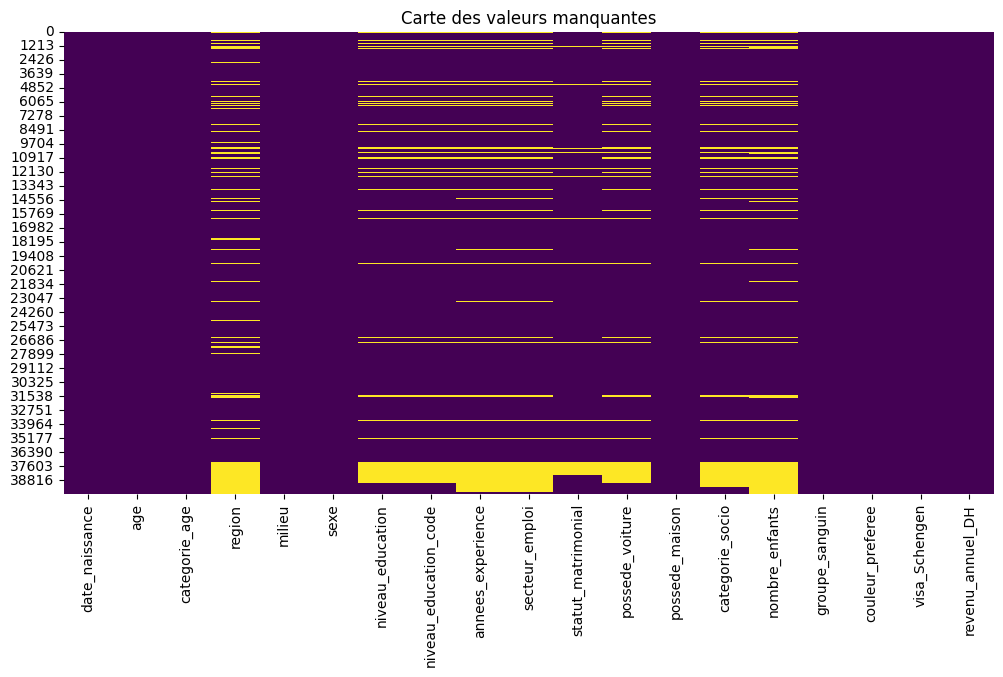

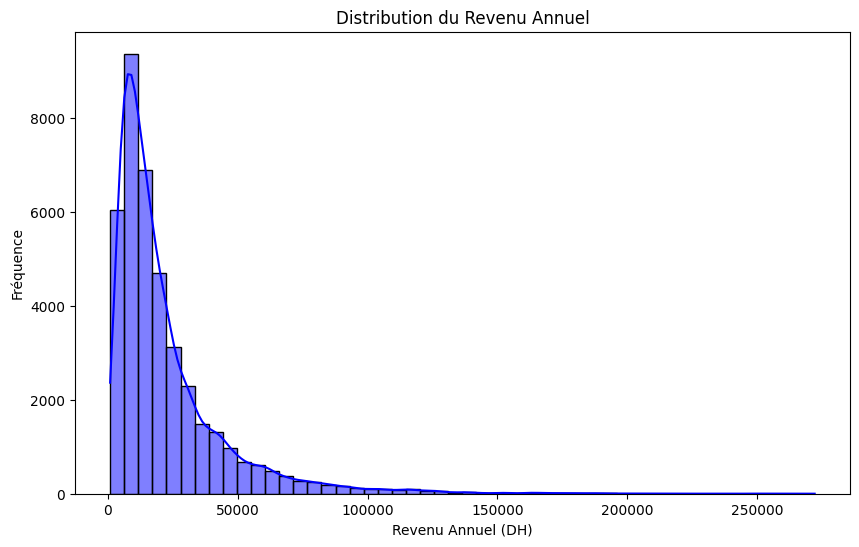

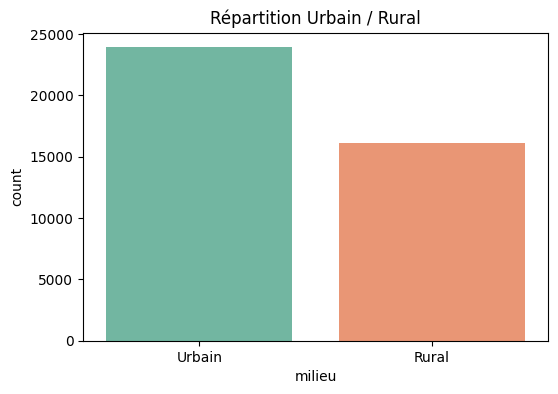

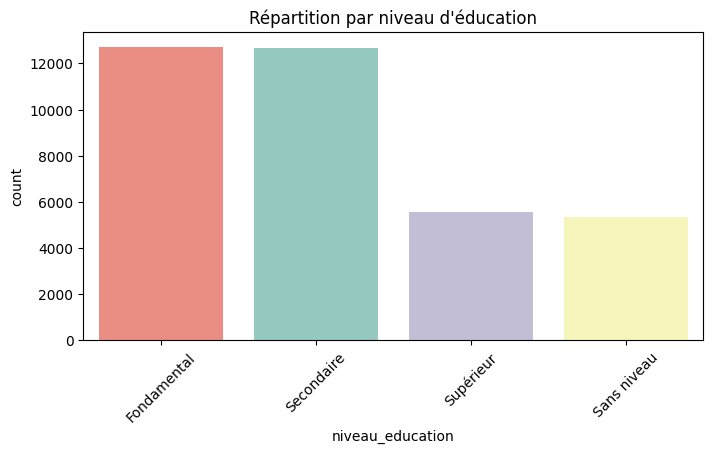

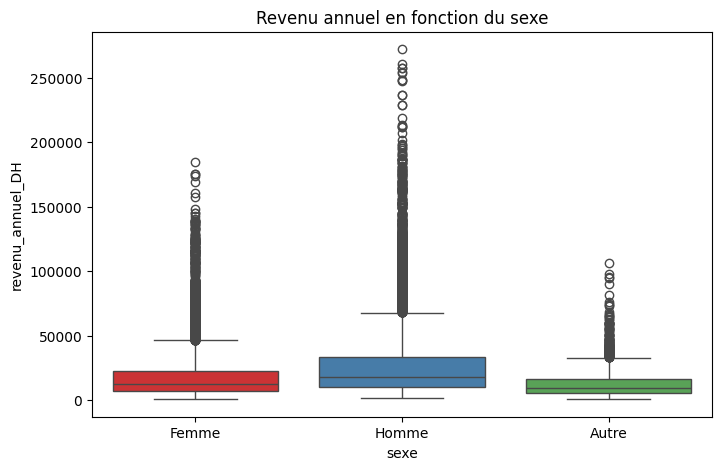

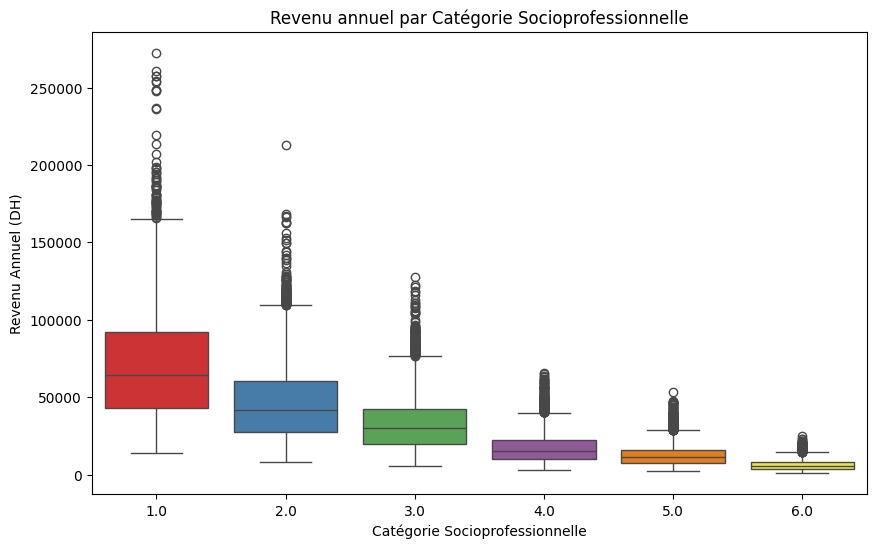


Génération du rapport d'exploration automatique...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 15.59it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
import seaborn as sns
from ydata_profiling import ProfileReport  # pour l'analyse automatique


# -------------------------
# 6. Analyse des valeurs manquantes
# -------------------------
print("\nNombre de valeurs manquantes par colonne :")
print(df.isnull().sum())

# Visualisation des valeurs manquantes
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Carte des valeurs manquantes')
plt.show()

# -------------------------
# 7. Exploration visuelle des données
# -------------------------

# Distribution du revenu annuel
plt.figure(figsize=(10,6))
sns.histplot(df['revenu_annuel_DH'], kde=True, color='blue', bins=50)
plt.title('Distribution du Revenu Annuel')
plt.xlabel('Revenu Annuel (DH)')
plt.ylabel('Fréquence')
plt.show()

# Répartition Urbain/Rural
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='milieu', hue='milieu', palette='Set2', legend=False)
plt.title('Répartition Urbain / Rural')
plt.show()

# Répartition par niveau d'éducation
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='niveau_education', hue='niveau_education', palette='Set3', order=df['niveau_education'].value_counts().index, legend=False)
plt.title('Répartition par niveau d\'éducation')
plt.xticks(rotation=45)
plt.show()

# Boxplot Revenu par Sexe
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='sexe', y='revenu_annuel_DH', hue='sexe', palette='Set1', legend=False)
plt.title('Revenu annuel en fonction du sexe')
plt.show()

# Boxplot Revenu par Catégorie Socio-Professionnelle
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='categorie_socio', y='revenu_annuel_DH', hue='categorie_socio', palette='Set1', legend=False)
plt.title('Revenu annuel par Catégorie Socioprofessionnelle')
plt.xlabel('Catégorie Socioprofessionnelle')
plt.ylabel('Revenu Annuel (DH)')
plt.show()

# -------------------------
# 8. Analyse automatique du dataset avec ydata-profiling
# -------------------------
print("\nGénération du rapport d'exploration automatique...")

profiling_report = ProfileReport(df, title="Rapport d'Exploration du Dataset", explorative=True)
profiling_report.to_notebook_iframe()  # Affiche direc tement dans le notebook
# Alternative pour sauvegarder : profiling_report.to_file("rapport_exploration.html")



# Etape 2: Le nettoyage de Données - Data Cleaning
Apres on a fait l’analyse exploratoire des données que vous avez effectué dans
l’étape précédente :

- **Éliminationt des doublons**
- **Traitement des valeurs manquantes**
- **Traitement des valeurs aberrantes**

## Vérification et suppression des Doublons

In [ ]:

print("Nombre de doublons :", df.duplicated().sum())

df = df.drop_duplicates()

print("Nouvelle taille du dataset :", df.shape)

## Traitement des Valeurs Manquantes

Nous proposons une methode comme l'imputer consiste a :
- Remplacer les valeurs manquantes numériques par la **médiane**.
- Remplacer les valeurs manquantes catégoriques par la **valeur la plus fréquente** (mode).

In [ ]:
# Remplir les colonnes numériques avec la médiane
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    median_value = df[col].median()
    df.loc[:, col] = df[col].fillna(median_value)

# Remplir les colonnes catégoriques avec la valeur la plus fréquente (mode)
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():  # Vérifier s'il y a des NaN
        mode_value = df[col].mode()[0]
        df.loc[:, col] = df[col].fillna(mode_value)
df.head(10)

### Francophonisation de Dataset et Remplacement d'autre

In [ ]:
df = df.replace({True: 'Vrai', False: 'Faux'})

# remplacement d'autre aleatoirement pas de contrainte
df['sexe'] = df['sexe'].apply(lambda x: x if x in ['homme', 'femme'] else random.choice(['homme', 'femme']))

df.head(30)



## Traitement des Valeurs Aberrantes (Outliers)

Nous proposons la méthode de l'écart interquartile (**IQR**) pour détecter et supprimer les valeurs aberrantes :
- Calcul des 1er et 3ème quartiles (Q1 et Q3)
- Suppression des observations en dehors de [Q1 - 1.5×IQR, Q3 + 1.5×IQR]

In [ ]:

# 1. Fonction pour afficher les visualisations avant et après le nettoyage
def tracer_distributions(df_avant, df_apres, colonnes):
    for col in colonnes:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f"Distributions de '{col}' (Avant vs Après nettoyage IQR)", fontsize=14)

        # Boxplot avant
        sns.boxplot(x=df_avant[col], ax=axes[0, 0], color='lightblue')
        axes[0, 0].set_title("Boîte à moustaches - Avant")

        # Histogramme avant
        sns.histplot(df_avant[col], kde=True, ax=axes[0, 1], color='skyblue')
        axes[0, 1].set_title("Histogramme - Avant")

        # Boxplot après
        sns.boxplot(x=df_apres[col], ax=axes[1, 0], color='lightgreen')
        axes[1, 0].set_title("Boîte à moustaches - Après")

        # Histogramme après
        sns.histplot(df_apres[col], kde=True, ax=axes[1, 1], color='mediumseagreen')
        axes[1, 1].set_title("Histogramme - Après")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# 2. Copier le DataFrame original pour comparaison
df_avant = df.copy()

# 3. Fonction de suppression des valeurs aberrantes par la méthode IQR
def supprimer_valeurs_aberrantes_iqr(df, colonnes):
    df_nettoye = df.copy()
    for col in colonnes:
        Q1 = df_nettoye[col].quantile(0.25)
        Q3 = df_nettoye[col].quantile(0.75)
        IQR = Q3 - Q1
        borne_inf = Q1 - 1.5 * IQR
        borne_sup = Q3 + 1.5 * IQR
        df_nettoye = df_nettoye[(df_nettoye[col] >= borne_inf) & (df_nettoye[col] <= borne_sup)]
    return df_nettoye

# 4. Appliquer la méthode IQR aux colonnes numériques
colonnes_numeriques = df.select_dtypes(include=['int64', 'float64']).columns
df_apres = supprimer_valeurs_aberrantes_iqr(df, colonnes_numeriques)

# 5. Afficher les visualisations pour les 3 premières colonnes numériques (modifiable)
tracer_distributions(df_avant, df_apres, colonnes_numeriques[:6])
# Calculs des statistiques de nettoyage
nb_avant = df_avant.shape[0]
nb_apres = df_apres.shape[0]
nb_supprimees = nb_avant - nb_apres
pourcentage_supprime = (nb_supprimees / nb_avant) * 100

# Affichage des résultats
print("=== Statistiques du nettoyage des valeurs aberrantes ===")
print(f"Nombre d'enregistrements avant nettoyage : {nb_avant}")
print(f"Nombre d'enregistrements après nettoyage : {nb_apres}")
print(f"Nombre d'enregistrements supprimés       : {nb_supprimees}")
print(f"Pourcentage supprimé                     : {pourcentage_supprime:.2f} %")


## Pipeline de Nettoyage
Et Afin de executer chaque fonction seul, on a decide de cree un pipeline de netoyage pour qu;il automatise le netoyage des donnees

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Étape 1 : Suppression des doublons
class SuppressionDoublons(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        forme_initiale = X.shape[0]
        X_sans_doublons = X.drop_duplicates()
        doublons_supprimes = forme_initiale - X_sans_doublons.shape[0]
        print(f"{doublons_supprimes} lignes doublons ont été supprimées.")
        return X_sans_doublons

# Étape 2 : Gestion des valeurs manquantes (méthode personnalisée)
class GestionValeursManquantes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        # Remplissage numérique par la médiane
        for col in X.select_dtypes(include=['int64', 'float64']).columns:
            median_value = X[col].median()
            X.loc[:, col] = X[col].fillna(median_value)
        
        # Remplissage catégorique par le mode
        for col in X.select_dtypes(include=['object']).columns:
            if X[col].isnull().any():
                mode_value = X[col].mode()[0]
                X.loc[:, col] = X[col].fillna(mode_value)
        
        valeurs_manquantes_apres = X.isnull().sum().sum()
        print(f"Valeurs manquantes traitées. Total restant : {valeurs_manquantes_apres}")
        return X

# Étape 3 : Gestion des valeurs aberrantes (méthode IQR)
class GestionValeursAberrantes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        forme_initiale = X.shape[0]
        df_clean = X.copy()
        
        for col in df_clean.select_dtypes(include=['int64', 'float64']).columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            borne_inf = Q1 - 1.5 * IQR
            borne_sup = Q3 + 1.5 * IQR
            df_clean = df_clean[(df_clean[col] >= borne_inf) & (df_clean[col] <= borne_sup)]
        
        valeurs_aberrantes_supprimees = forme_initiale - df_clean.shape[0]
        print(f"{valeurs_aberrantes_supprimees} lignes aberrantes supprimées.")
        return df_clean

# Étape 4 : Nettoyage complémentaire
class NettoyageComplementaire(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['sexe'] = X['sexe'].apply(lambda x: x if x in ['homme', 'femme'] else random.choice(['homme', 'femme']))
        print("Nettoyage complémentaire appliqué (correction des valeurs catégorielles).")
        return X

# Création du pipeline
pipeline_nettoyage_donnees = Pipeline([
    ('suppression_doublons', SuppressionDoublons()),
    ('gestion_valeurs_manquantes', GestionValeursManquantes()),
    ('gestion_valeurs_aberrantes', GestionValeursAberrantes()),
    ('nettoyage_complementaire', NettoyageComplementaire())
])

# Application du pipeline
print(f"Forme initiale des données : {df.shape}")
print(f"Valeurs manquantes initiales :\n{df.isnull().sum()}")

# Transformation du DataFrame
df = pipeline_nettoyage_donnees.fit_transform(df)

print("\nDataFrame nettoyé :")
print(df)
print(f"\nForme finale : {df.shape}")
print(f"Valeurs manquantes résiduelles :\n{df.isnull().sum()}")

Forme initiale des données : (40000, 19)
Valeurs manquantes initiales :
date_naissance              0
age                         0
categorie_age               0
region                   6520
milieu                      0
sexe                        0
niveau_education         3720
niveau_education_code    3720
annees_experience        5208
secteur_emploi           5208
statut_matrimonial       2232
possede_voiture          3720
possede_maison              0
categorie_socio          4464
nombre_enfants           5776
groupe_sanguin              0
couleur_preferee            0
visa_Schengen               0
revenu_annuel_DH            0
dtype: int64
2800 lignes doublons ont été supprimées.
Valeurs manquantes traitées. Total restant : 0
4953 lignes aberrantes supprimées.
Nettoyage complémentaire appliqué (correction des valeurs catégorielles).

DataFrame nettoyé :
      date_naissance  age categorie_age                     region  milieu  \
0         2000-04-15   25        Adulte         R

C:\Users\moha-\AppData\Local\Temp\ipykernel_9740\708612391.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.loc[:, col] = X[col].fillna(mode_value)


## Conclusion du Nettoyage

À l'issue de cette étape :
- Les doublons ont été supprimés.
- Les valeurs manquantes ont été traitées de manière appropriée.
- Les valeurs aberrantes ont été éliminées pour assurer une meilleure qualité de données.

Nous sommes maintenant prêts à passer à la phase de Transformation des données.

# Transformation des données

### Suppression de colonnes non pertinentes et redondantes

Dans l'etape de transformation des données, nous avons choisi de supprimer **quatre colonnes** jugées non pertinentes ou redondantes pour la prédiction du revenu annuel.

### Colonnes supprimées :

- **Non pertinentes** :
  - `couleur_preferee` : Il s'agit d'une variable subjective qui ne présente **aucun lien logique ou statistique** avec le revenu annuel. Elle reflète les préférences personnelles sans impact socio-économique mesurable.
  - `groupe_sanguin` : Le groupe sanguin est une donnée **biologique fixe**, qui n'a **aucune influence directe ou indirecte sur le revenu**. Elle est donc inutile dans ce contexte prédictif.

- **Redondantes** :
  - `date_naissance` : Cette colonne est redondante avec l'attribut `age`, qui est déjà disponible et plus exploitable directement dans un modèle.
  - `niveau_education_code` : Ce champ est un code qui **duplique l'information contenue dans `niveau_education`** (ex. : primaire, secondaire, universitaire, etc.). Garder les deux introduirait une redondance.


In [ ]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['date_naissance', 'niveau_education_code', 'groupe_sanguin', 'couleur_preferee']

# Suppression des colonnes du DataFrame
df = df.drop(columns=colonnes_a_supprimer)

# Aperçu après suppression
print("Aperçu des données après suppression des colonnes non pertinentes/redondantes :")
display(df.head())

## La Création de nouveaux attributs prédictifs
Pour cette étape, on a décidé de créer deux nouvelles colonnes à partir de données existantes pour mieux représenter certaines informations importantes.

### 1. Création de la colonne `type_logement`

On a décidé de créer une nouvelle colonne appelée `type_logement` de type catégoriel.  
Cette colonne dépend de la valeur du `salaire_annuel` de la personne. Elle permet de catégoriser les individus selon leur niveau de vie.

Voici les intervalles et les étiquettes associées :

- 0 à 10 000 → **Logement Basique** 
- 10 000 à 20 000 → **Logement Standard**  
- 150 000 à 350 000 → **Logement Confort**  
- 350 000 à 700 000 → **Logement Supérieur**  
- Supérieur à 700 000 → **Résidence Prestige**

### 2. Fusion des colonnes `possede_voiture` et `possede_maison`

On a également décidé de fusionner les colonnes `possede_voiture` et `possede_maison` en une seule colonne appelée `possede_bien`, de type booléen.  
Le but est de simplifier la représentation des possessions matérielles d’une personne.

La fusion est faite avec un opérateur logique **OU**, ce qui signifie :

- Si la personne possède **au moins** une voiture **ou** une maison → `True`  
- Sinon → `False`

Ces deux transformations permettent de réduire la complexité du jeu de données tout en gardant des informations utiles pour la prédiction.


In [ ]:
# Définition des tranches de salaire
bins = [0, 10000, 20000, 30000, 50000, float('inf')]
labels = [
    'Logement Basique',
    'Logement Standard', 
    'Logement Confort',
    'Logement Supérieur',
    'Résidence Prestige'
]

# Création de la colonne 'type_logement'
df['type_logement'] = pd.cut(df['revenu_annuel_DH'], bins=bins, labels=labels)

# Déplacer la colonne juste après 'status_matrimonial'
index_matrimonial = df.columns.get_loc('statut_matrimonial')
colonne_temp = df.pop('type_logement')
df.insert(index_matrimonial + 1, 'type_logement', colonne_temp)


df.head(20)

In [ ]:
# Ensure the columns are of boolean type (True/False)
df['possede_voiture'] = df['possede_voiture']
df['possede_maison'] = df['possede_maison']

# Determine the index of the first column (possede_voiture or possede_maison)
min_index = min(df.columns.get_loc('possede_voiture'), df.columns.get_loc('possede_maison'))

# Create the merged column 'possesion_bien' using the OR operation
df.insert(min_index, 'possesion_bien', df['possede_voiture'] | df['possede_maison'])


df.drop(columns=['possede_voiture', 'possede_maison'], inplace=True)

# Display the first 10 rows to verify the result
df.head(20)


## La Normalisation des donnees

### Normalisation des données

Après les deux dernières étapes, on passe à **la normalisation des données**.  
Parmi les méthodes disponibles, on a choisi d’appliquer la **méthode de min-max scaling** définie par la formule suivante :

> **(x - x_min) / (x_max - x_min)**

Cette méthode permet d’obtenir une **normalisation plus précise**, avec des valeurs comprises dans l’**intervalle [0, 1]**.

Les colonnes sur lesquelles nous appliquons cette transformation sont :

- `age`  
- `annees_experience`  
- `categorie_socio`  
- `nombre_enfant`


In [ ]:
# Liste des colonnes à normaliser
colonnes_a_normaliser = ['age', 'annees_experience', 'categorie_socio', 'nombre_enfants']

# Application de la normalisation min-max
for col in colonnes_a_normaliser:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)

# Aperçu des données après normalisation
df[colonnes_a_normaliser].head(10)


#### Interprétation des valeurs normalisées (entre 0 et 1)

Voici comment interpréter les valeurs normalisées pour chaque colonne, y compris les valeurs avec des décimales :

- **age** :
  - **0.0** : personne la plus jeune dans l’ensemble de données
  - **0.1 à 0.3** : individus jeunes 
  - **0.4 à 0.6** : individus d’âge moyen
  - **0.7 à 0.9** : personnes proches de la retraite
  - **1.0** : personne la plus âgée de l’échantillon
- **annees_experience** :
  - **0.0** : aucune expérience 
  - **0.1 à 0.3** : faible expérience 
  - **0.4 à 0.6** : expérience moyenne
  - **0.7 à 0.9** : expérience solide ou senior
  - **1.0** : personne la plus expérimentée dans le dataset
- **categorie_socio** (6 groupes) :
  - **0.0** : appartenant au groupe socio-économique le plus bas 
  - **0.2** : groupe socio-économique légèrement supérieur 
  - **0.4** : groupe socio-économique intermédiaire 
  - **0.6** : groupe socio-économique relativement élevé
  - **0.8** : groupe socio-économique proche du haut de la pyramide
  - **1.0** : groupe socio-économique le plus élevé

- **nombre_enfant** :
  - **0.0** : sans enfant
  - **0.1 à 0.3** : 1 à 2 enfants
  - **0.4 à 0.6** : 3 à 4 enfants
  - **0.7 à 0.9** : famille nombreuse
  - **1.0** : personne avec le plus grand nombre d’enfants du dataset



 ## La Transformation des donnees

### Transformation des variables catégorielles en variables numériques

Pour entraîner un modèle de Machine Learning, il est nécessaire de transformer les variables de type **catégoriel** en **valeurs numériques**. Pour cela, nous avons appliqué deux types d’encodage :



#### 1. **Encodage ordinal**

Ce type d'encodage est utilisé lorsque les catégories ont un **ordre logique** ou **hiérarchique**. Il consiste à attribuer une valeur numérique croissante selon le rang de la catégorie.

Les colonnes concernées par cet encodage sont :

- **categorie_age** : (ex. jeune, adulte, senior, age)
- **niveau_education** : (ex. Sans niveau, Fondamental, Secondaire, Superieur)

Ces colonnes ont été encodées manuellement selon leur ordre logique.


#### 2. **One-Hot Encoding**

Ce type d'encodage est utilisé lorsque les catégories sont **indépendantes** et sans relation d'ordre entre elles. Il consiste à créer une nouvelle colonne pour chaque valeur unique de la variable, contenant des 0 ou 1 selon la présence ou non de la catégorie.

Les colonnes concernées par le One-Hot Encoding sont :

- **secteur_emploi**
- **statut_matrimonial**
- **region**
- **milieu**
- **sexe**
- **possesion_bien**

Chaque modalité de ces colonnes sera transformée en une variable binaire.


In [ ]:
# Encodage ordinal
categorie_age_map = {'Jeune': 0, 'Adulte': 0.33, 'Senior': 0.66, 'Âgé': 1}
niveau_education_map = {'Sans niveau': 0, 'Fondamental': 0.33, 'Secondaire': 0.66, 'Supérieur': 1}

df['categorie_age'] = df['categorie_age'].map(categorie_age_map)
df['niveau_education'] = df['niveau_education'].map(niveau_education_map)

# Aperçu des données après transformation
df.head(20)

In [ ]:
# One-Hot Encoding des colonnes catégorielles
colonnes_onehot = ['secteur_emploi', 'type_logement','statut_matrimonial', 'region', 'milieu', 'sexe']

# Appliquer le One-Hot Encoding
df = pd.get_dummies(df, columns=colonnes_onehot)

# Aperçu des données après transformation
df.head(10)

Ensuite, nous allons convertir toutes les valeurs booléennes **True** et **False** en valeurs numériques **1 et 0** respectivement.

In [ ]:
# Conversion des booléens en 1 (True) et 0 (False)
df = df.replace({True: 1, False: 0})

# Affichage
df.head(10)

## Pipeline de Transformation des donnees

Voici une pipline qui resume tous la partie de transformation des donnees


In [7]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class SuppressionColonnes(BaseEstimator, TransformerMixin):
    def __init__(self, colonnes_a_supprimer):
        self.colonnes_a_supprimer = colonnes_a_supprimer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.colonnes_a_supprimer)

class CreationAttributs(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        bins = [0, 10000, 20000, 30000, 50000, float('inf')]
        labels = ['Logement Basique', 'Logement Standard', 'Logement Confort', 
                'Logement Supérieur', 'Résidence Prestige']
        
        X['type_logement'] = pd.cut(X['revenu_annuel_DH'], bins=bins, labels=labels)
        X.insert(X.columns.get_loc('statut_matrimonial') + 1, 
                'type_logement', 
                X.pop('type_logement'))
        
        min_index = min(X.columns.get_loc('possede_voiture'), 
                      X.columns.get_loc('possede_maison'))
        X.insert(min_index, 'possesion_bien', X['possede_voiture'] | X['possede_maison'])
        return X.drop(columns=['possede_voiture', 'possede_maison'])

class Normalisation(BaseEstimator, TransformerMixin):
    def __init__(self, colonnes_a_normaliser):
        self.colonnes_a_normaliser = colonnes_a_normaliser
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in self.colonnes_a_normaliser:
            min_val = X[col].min()
            max_val = X[col].max()
            X[col] = (X[col] - min_val) / (max_val - min_val)
        return X

class TransformationDonnees(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        categorie_age_map = {'Jeune':0, 'Adulte':0.33, 'Senior':0.66, 'Âgé':1}
        niveau_education_map = {'Sans niveau':0, 'Fondamental':0.33, 
                              'Secondaire':0.66, 'Supérieur':1}
        
        X['categorie_age'] = X['categorie_age'].map(categorie_age_map)
        X['niveau_education'] = X['niveau_education'].map(niveau_education_map)
        
        colonnes_onehot = ['secteur_emploi', 'type_logement', 
                         'statut_matrimonial', 'region', 
                         'milieu', 'sexe']
        return pd.get_dummies(X, columns=colonnes_onehot).replace({True:1, False:0})

# Création et application du pipeline
pipeline = Pipeline([
    ('suppression_colonnes', SuppressionColonnes(
        ['date_naissance', 'niveau_education_code', 'groupe_sanguin', 'couleur_preferee'])),
    ('creation_attributs', CreationAttributs()),
    ('normalisation', Normalisation(['age', 'annees_experience', 'categorie_socio', 'nombre_enfants'])),
    ('transformation', TransformationDonnees())
])

print("=== Transformation des données ===")
print(f"Dimensions initiales : {df.shape}")
print("Colonnes initiales :", df.columns.tolist())

# Application du pipeline avec écrasement
df = pipeline.fit_transform(df)

print("\n=== Résultats finaux ===")
print(f"Nouvelles dimensions : {df.shape}")
print("Nouvelles colonnes :", df.columns.tolist())
print("\nAperçu des données :")
display(df.head(20))
df.to_csv("dataset_revenu_marocains.csv", index=False)

=== Transformation des données ===
Dimensions initiales : (32247, 19)
Colonnes initiales : ['date_naissance', 'age', 'categorie_age', 'region', 'milieu', 'sexe', 'niveau_education', 'niveau_education_code', 'annees_experience', 'secteur_emploi', 'statut_matrimonial', 'possede_voiture', 'possede_maison', 'categorie_socio', 'nombre_enfants', 'groupe_sanguin', 'couleur_preferee', 'visa_Schengen', 'revenu_annuel_DH']


C:\Users\moha-\AppData\Local\Temp\ipykernel_9740\155695236.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return pd.get_dummies(X, columns=colonnes_onehot).replace({True:1, False:0})



=== Résultats finaux ===
Nouvelles dimensions : (32247, 40)
Nouvelles colonnes : ['age', 'categorie_age', 'niveau_education', 'annees_experience', 'possesion_bien', 'categorie_socio', 'nombre_enfants', 'visa_Schengen', 'revenu_annuel_DH', 'secteur_emploi_Agriculture', 'secteur_emploi_Chômeur', 'secteur_emploi_Industrie', 'secteur_emploi_Privé', 'secteur_emploi_Public', 'secteur_emploi_Services', 'type_logement_Logement Basique', 'type_logement_Logement Standard', 'type_logement_Logement Confort', 'type_logement_Logement Supérieur', 'type_logement_Résidence Prestige', 'statut_matrimonial_Célibataire', 'statut_matrimonial_Divorcé(e)', 'statut_matrimonial_Marié(e)', 'statut_matrimonial_Veuf(ve)', 'region_Béni_Mellal_Khénifra', 'region_Casablanca_Settat', 'region_Dakhla_Oued_Ed_Dahab', 'region_Drâa_Tafilalet', 'region_Fès_Meknès', 'region_Guelmim_Oued_Noun', 'region_Laâyoune_Sakia_El_Hamra', 'region_Marrakech_Safi', 'region_Oriental', 'region_Rabat_Salé_Kénitra', 'region_Souss_Massa', 're

age  categorie_age  niveau_education  annees_experience  \
0   0.191489           0.33              0.66           0.066667   
1   0.085106           0.00              0.00           0.000000   
2   0.170213           0.00              0.00           0.133333   
3   0.510638           0.66              1.00           0.422222   
4   0.510638           0.66              0.33           0.422222   
5   0.148936           0.00              0.66           0.066667   
6   0.553191           0.66              1.00           0.533333   
7   0.489362           0.33              0.66           0.400000   
9   0.297872           0.33              1.00           0.200000   
10  0.531915           0.66              0.00           0.488889   
11  0.425532           0.33              1.00           0.311111   
12  0.404255           0.33              0.33           0.311111   
13  0.702128           0.66              0.33           0.422222   
14  0.957447           1.00              0.33           0.911111   
15  0.872340           0.66              0.33           0.844444   
17  0.468085           0.33              0.00           0.444444   
18  0.808511           0.66              0.66           0.733333   
19  0.978723           1.00              0.66           0.977778   
20  0.000000           0.00              0.33           0.000000   
21  0.063830           0.00              0.33           0.000000   

    possesion_bien  categorie_socio  nombre_enfants  visa_Schengen  \
0                1              0.4        0.666667              0   
1                1              0.6        0.333333              0   
2                1              0.8        0.333333              0   
3                1              0.6        0.333333              0   
4                1              0.6        0.333333              1   
5                1              0.8        0.333333              0   
6                1              0.4        0.333333              0   
7                1              1.0        0.333333              1   
9                1              1.0        1.000000              0   
10               1              1.0        0.000000              0   
11               1              0.8        0.333333              0   
12               1              0.8        1.000000              0   
13               0              0.6        0.333333              0   
14               1              0.2        0.333333              1   
15               1              0.4        0.000000              0   
17               1              0.6        0.333333              0   
18               1              0.4        0.333333              0   
19               1              0.0        0.000000              0   
20               1              0.8        0.666667              0   
21               1              1.0        1.000000              0   

    revenu_annuel_DH  secteur_emploi_Agriculture  ...  \
0           30487.32                           1  ...   
1           13294.92                           0  ...   
2            4513.50                           0  ...   
3           26290.70                           0  ...   
4           24600.42                           0  ...   
5            4567.67                           0  ...   
6           54716.99                           0  ...   
7           11436.65                           0  ...   
9            9075.81                           0  ...   
10           7134.82                           0  ...   
11          13630.20                           0  ...   
12           4553.26                           0  ...   
13          29342.89                           0  ...   
14          30232.49                           1  ...   
15          13773.91                           1  ...   
17           7116.72                           0  ...   
18          41225.93                           0  ...   
19          43818.63                           0  ...   
20           7973.15      

# 6.4. Séparation des données

Nous allons diviser notre jeu de données en deux sous-ensembles :

- **Sous-ensemble d’apprentissage** : 70 % des données, utilisé pour entraîner le modèle.
- **Sous-ensemble de test** : 30 % des données, utilisé pour évaluer la performance du modèle sur des données non vues.

Cette séparation permet d’éviter le surapprentissage et de tester la capacité de généralisation du modèle.


In [8]:
# Importation nécessaire
from sklearn.model_selection import train_test_split
import pandas as pd

# Chargement des données (si nécessaire)
# df = pd.read_csv('moroccan_income_cleaned.csv')

# Séparation des features (X) et de la target (y)
X = df.drop(columns=['revenu_annuel_DH'])  # Toutes les colonnes sauf la target
y = df['revenu_annuel_DH']                 # Uniquement la colonne target

# Séparation train/test (70%/30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,  # Pour la reproductibilité
    shuffle=True      # Mélange aléatoire des données
)

# Réinitialisation des index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Vérification
print("=== Séparation des données ===")
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de y_test: {y_test.shape}\n")

# Aperçu des données
print("Aperçu des features d'entraînement:")
display(X_train.head())
print("\nAperçu des target d'entraînement:")
display(y_train.head())

=== Séparation des données ===
Dimensions de X_train: (22572, 39)
Dimensions de X_test: (9675, 39)
Dimensions de y_train: (22572,)
Dimensions de y_test: (9675,)

Aperçu des features d'entraînement:


age  categorie_age  niveau_education  annees_experience  \
0  0.297872           0.33              0.00           0.177778   
1  0.914894           0.66              1.00           0.866667   
2  0.489362           0.33              0.66           0.466667   
3  0.361702           0.33              0.00           0.422222   
4  0.234043           0.33              0.33           0.177778   

   possesion_bien  categorie_socio  nombre_enfants  visa_Schengen  \
0               0              1.0        0.000000              0   
1               1              0.6        0.000000              0   
2               0              1.0        0.666667              0   
3               1              0.6        0.333333              1   
4               1              0.4        0.000000              0   

   secteur_emploi_Agriculture  secteur_emploi_Chômeur  ...  \
0                           0                       0  ...   
1                           1                       0  ...   
2                           0                       0  ...   
3                           0                       0  ...   
4                           1                       0  ...   

   region_Laâyoune_Sakia_El_Hamra  region_Marrakech_Safi  region_Oriental  \
0                               0                      0                0   
1                               0                      0                0   
2                               0                      0                0   
3                               0                      0                1   
4                               0                      0                0   

   region_Rabat_Salé_Kénitra  region_Souss_Massa  \
0                          0                   0   
1                          0                   0   
2                          0                   0   
3                          0                   0   
4                          0                   0   

   region_Tanger_Tétouan_Al_Hoceïma  milieu_Rural  milieu_Urbain  sexe_femme  \
0                                 0             0              1           0   
1                                 0             1              0           1   
2                                 0             1              0           1   
3                                 0             1              0           0   
4                                 1             1              0           1   

   sexe_homme  
0           1  
1           0  
2           0  
3           1  
4           0  

[5 rows x 39 columns]


Aperçu des target d'entraînement:


0     5051.79
1    22080.49
2     4652.44
3     3049.43
4    17377.79
Name: revenu_annuel_DH, dtype: float64

# 6.5. Création et validation des modèles

### 1. Régression Linéaire (`LinearRegression`)

La régression linéaire modélise la relation entre les variables indépendantes et la variable cible par une équation linéaire. C’est un modèle simple, rapide à entraîner et interprétable.  
**Hyperparamètres :** Aucun à ajuster dans la version de base.

=== Régression Linéaire ===
Entraînement du modèle...

=== Performance du modèle ===
MAE (Erreur Absolue Moyenne): 2059.62 DH
RMSE (Racine de l'Erreur Quadratique Moyenne): 2789.69 DH
R² (Coefficient de Détermination): 0.9491

Top 10 des variables les plus influentes:


Variable   Coefficient
18  type_logement_Résidence Prestige  22022.792281
17  type_logement_Logement Supérieur   8712.101443
2                   niveau_education   3825.574990
0                                age   1781.900469
36                     milieu_Urbain   1626.749179
7                      visa_Schengen   1276.845010
1                      categorie_age    333.926228
3                  annees_experience    278.308729
25       region_Dakhla_Oued_Ed_Dahab     98.803314
28          region_Guelmim_Oued_Noun     71.759668

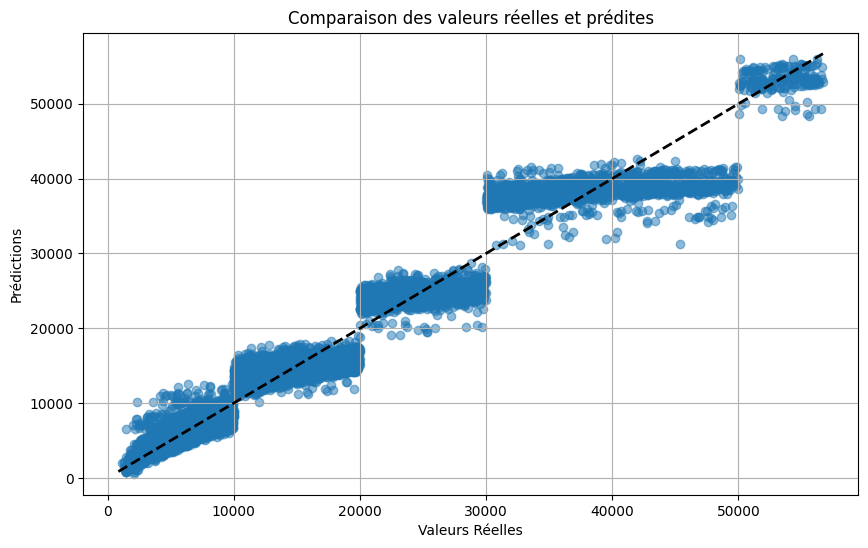

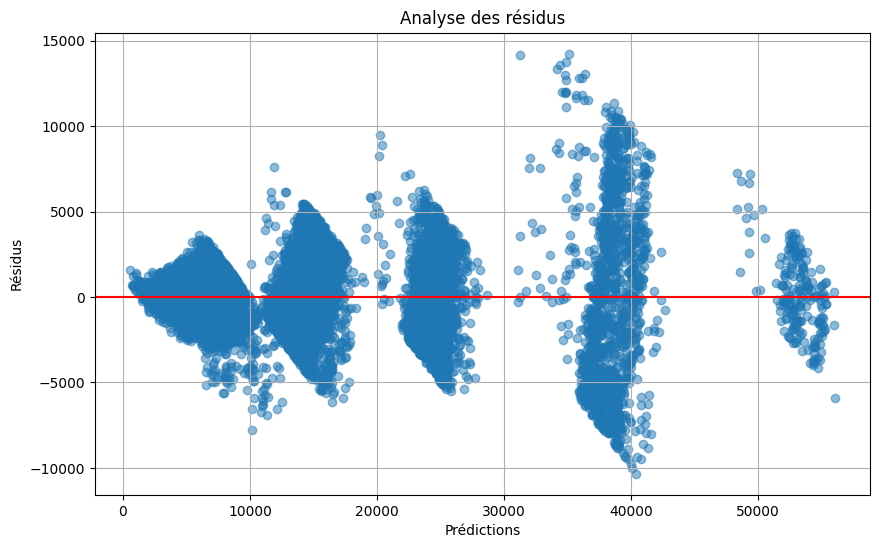

In [11]:
# Importations nécessaires
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1. Initialisation du modèle
print("=== Régression Linéaire ===")
lr_model = LinearRegression()

# 2. Entraînement du modèle
print("Entraînement du modèle...")
lr_model.fit(X_train, y_train)

# 3. Prédiction et évaluation sur le test set
y_pred = lr_model.predict(X_test)

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 4. Affichage des résultats
print("\n=== Performance du modèle ===")
print(f"MAE (Erreur Absolue Moyenne): {mae:.2f} DH")
print(f"RMSE (Racine de l'Erreur Quadratique Moyenne): {rmse:.2f} DH")
print(f"R² (Coefficient de Détermination): {r2:.4f}")

# 5. Affichage des coefficients (optionnel)
coefficients = pd.DataFrame({
    'Variable': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nTop 10 des variables les plus influentes:")
display(coefficients.head(10))

# 6. Visualisation des prédictions vs réelles (optionnel)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des valeurs réelles et prédites')
plt.grid(True)
plt.show()

# 7. Analyse des résidus (optionnel)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Analyse des résidus')
plt.grid(True)
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
import joblib

# Entraînement final du modèle
final_model = LinearRegression()
final_model.fit(X_train, y_train)

# Sauvegarde du modèle
joblib.dump(final_model, 'linear_regression_model.joblib')

['linear_regression_model.joblib']

### 2. Arbres de Décision (`DecisionTreeRegressor`)

Les arbres de décision partitionnent l’espace des variables en régions homogènes selon la cible. Ils peuvent modéliser des relations complexes mais risquent de sur-apprendre si non régularisés.  
**Hyperparamètres à tester :**
- `criterion`: ['squared_error', 'absolute_error']  
- `max_depth`: [None, 5, 6, 7, 10]  
- `min_samples_split`: [2, 3, 4, 5, 10]


In [9]:
# Importations nécessaires
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Initialisation du modèle
dt_model = DecisionTreeRegressor(random_state=42)

# 2. Définition de la grille d'hyperparamètres
param_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 5, 6, 7, 10],
    'min_samples_split': [2, 3, 4, 5, 10]
}

# 3. Configuration et exécution de la validation croisée
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# 4. Meilleurs paramètres
best_params = grid_search.best_params_
print(f"\nMeilleurs hyperparamètres: {best_params}")

# 5. Évaluation avec les meilleurs paramètres
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

# Calcul des métriques
metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R2': r2_score(y_test, y_pred)
}

print("\nMétriques d'évaluation:")
print(f"MAE: {metrics['MAE']:.2f} DH")
print(f"RMSE: {metrics['RMSE']:.2f} DH")
print(f"R2: {metrics['R2']:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Meilleurs hyperparamètres: {'criterion': 'absolute_error', 'max_depth': 10, 'min_samples_split': 4}

Métriques d'évaluation:
MAE: 1830.69 DH
RMSE: 2793.07 DH
R2: 0.9490


### 3. Forêts Aléatoires (`RandomForestRegressor`)

Il s'agit d’un ensemble d’arbres de décision construits sur des échantillons aléatoires des données et des variables. Plus robuste qu’un arbre seul, il offre de bonnes performances sans beaucoup de réglage.  
**Hyperparamètres à tester :**
- `n_estimators`: [50, 100, 150, 200]  
- `criterion`: ['squared_error', 'absolute_error']  
- `max_depth`: [None, 5, 10, 15, 20]

In [7]:
# Importations nécessaires
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Initialisation du modèle
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# 2. Définition de la grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 5, 10, 15, 20]
}

# 3. Configuration de la validation croisée
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# 4. Recherche des meilleurs hyperparamètres
print("Optimisation du Random Forest en cours...")
grid_search.fit(X_train, y_train)

# 5. Affichage des meilleurs paramètres
print(f"\nMeilleurs hyperparamètres trouvés: {grid_search.best_params_}")

# 6. Évaluation du modèle optimisé
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calcul des métriques
metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R2': r2_score(y_test, y_pred)
}

# 7. Affichage des résultats
print("\nPerformance du modèle optimisé:")
print(f"MAE: {metrics['MAE']:.2f} DH")
print(f"RMSE: {metrics['RMSE']:.2f} DH")
print(f"R²: {metrics['R2']:.4f}")

Optimisation du Random Forest en cours...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Meilleurs hyperparamètres trouvés: {'criterion': 'squared_error', 'max_depth': 15, 'n_estimators': 200}

Performance du modèle optimisé:
MAE: 1752.54 DH
RMSE: 2552.95 DH
R²: 0.9574


In [9]:
from sklearn.ensemble import RandomForestRegressor
import joblib

# Entraînement final du modèle
final_model = RandomForestRegressor()
final_model.fit(X_train, y_train)

# Sauvegarde du modèle
joblib.dump(final_model, 'RandomForestRegressor_model.joblib')
print("Modèle sauvegardé avec succès!")

Modèle sauvegardé avec succès!


### 4. Gradient Boosting (`GradientBoostingRegressor`)

Méthode d’ensemble qui construit les arbres séquentiellement, chaque nouvel arbre corrigeant les erreurs du précédent. Plus précis mais plus lent à entraîner.  
**Hyperparamètres à tester :**
- `loss`: ['squared_error', 'absolute_error']  
- `learning_rate`: [0.01, 0.1, 0.2]  
- `n_estimators`: [100, 200, 300]  
- `subsample`: [0.5, 0.8, 1]


=== Optimisation du Gradient Boosting ===
Début de la recherche des hyperparamètres...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Meilleurs hyperparamètres trouvés:
{'learning_rate': 0.2, 'loss': 'absolute_error', 'n_estimators': 300, 'subsample': 1}

=== Performance du modèle ===
MAE (Erreur Absolue Moyenne): 1872.69 DH
RMSE (Racine de l'Erreur Quadratique Moyenne): 2643.54 DH
R² (Coefficient de Détermination): 0.9543


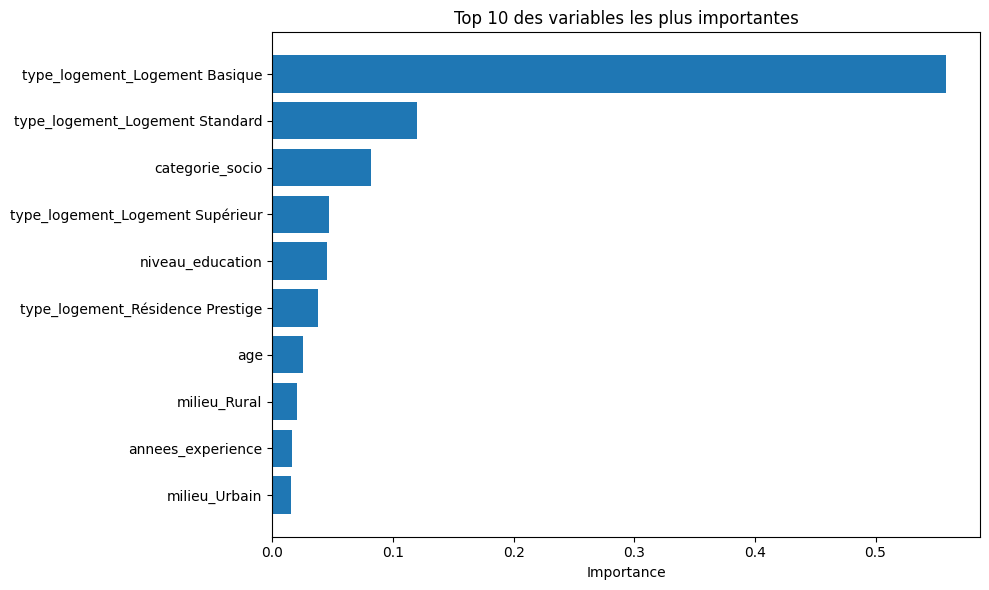

In [8]:
# Importations nécessaires
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialisation du modèle
gb_model = GradientBoostingRegressor(random_state=42)

# 2. Définition de la grille d'hyperparamètres
param_grid = {
    'loss': ['squared_error', 'absolute_error'],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.8, 1]
}

# 3. Configuration de la recherche par validation croisée
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Métrique d'optimisation
    n_jobs=-1,                  # Utilisation de tous les cœurs CPU
    verbose=1                   # Affichage détaillé
)

# 4. Recherche des meilleurs hyperparamètres
print("=== Optimisation du Gradient Boosting ===")
print("Début de la recherche des hyperparamètres...")
grid_search.fit(X_train, y_train)

# 5. Meilleurs paramètres et modèle
print("\nMeilleurs hyperparamètres trouvés:")
print(grid_search.best_params_)

best_gb = grid_search.best_estimator_

# 6. Prédiction et évaluation sur le test set
y_pred = best_gb.predict(X_test)

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 7. Affichage des résultats
print("\n=== Performance du modèle ===")
print(f"MAE (Erreur Absolue Moyenne): {mae:.2f} DH")
print(f"RMSE (Racine de l'Erreur Quadratique Moyenne): {rmse:.2f} DH")
print(f"R² (Coefficient de Détermination): {r2:.4f}")

# 8. Importance des variables (optionnel)
feature_importance = best_gb.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Top 10 des variables les plus importantes')
plt.tight_layout()
plt.show()

### 5. Réseaux de Neurones Multi-Couches (`MLPRegressor`)

Modèle inspiré du fonctionnement des neurones biologiques. Capable de modéliser des relations très complexes, mais nécessite une normalisation des données et une optimisation poussée.  
**Hyperparamètres à tester :**
- `hidden_layer_sizes`: [(50,), (100,), (100, 50), (100, 100)]  
- `activation`: ['relu', 'tanh', 'logistic']  
- `solver`: ['adam', 'sgd']  
- `alpha`: [0.0001, 0.001, 0.01]  
- `learning_rate`: ['constant', 'invscaling', 'adaptive']  
- `learning_rate_init`: [0.001, 0.01, 0.1]  
- `max_iter`: [100, 200, 300]


=== Optimisation du MLPRegressor ===
Début de la recherche des hyperparamètres... (peut prendre du temps)
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits

Meilleurs hyperparamètres trouvés:
{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 200, 'solver': 'adam'}

=== Performance du modèle ===
MAE (Erreur Absolue Moyenne): 2002.10 DH
RMSE (Racine de l'Erreur Quadratique Moyenne): 2720.88 DH
R² (Coefficient de Détermination): 0.9516


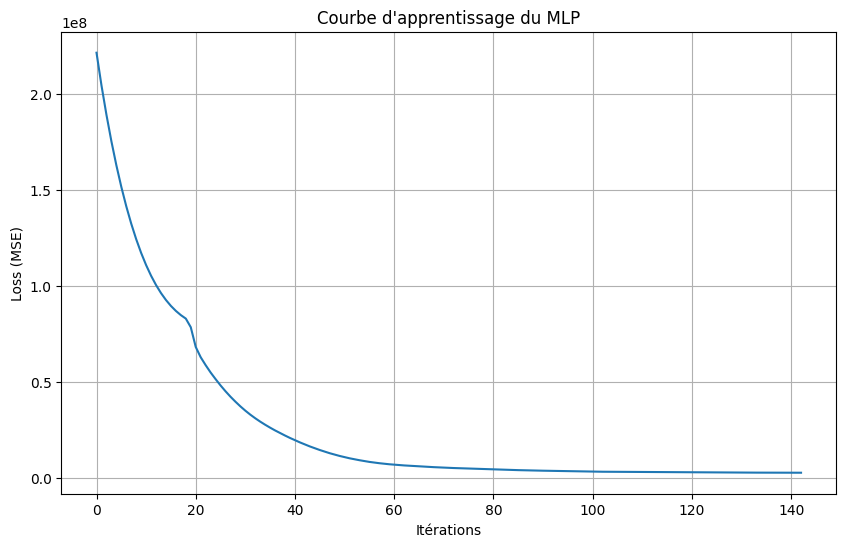


Top 5 des combinaisons d'hyperparamètres:


param_hidden_layer_sizes param_activation  param_alpha  mean_test_score  \
1618                   (100,)         logistic        0.001     -2021.688016   
1616                   (100,)         logistic        0.001     -2021.688016   
1598                   (100,)         logistic        0.001     -2021.688016   
1600                   (100,)         logistic        0.001     -2021.688016   
1582                   (100,)         logistic        0.001     -2021.688016   

      rank_test_score  
1618                1  
1616                1  
1598                1  
1600                1  
1582                1

In [9]:
# Importations nécessaires
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filtrer les warnings de convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Initialisation du modèle
mlp_model = MLPRegressor(random_state=42, early_stopping=True)

# 2. Définition de la grille d'hyperparamètres
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],  # Terme de régularisation L2
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [100, 200, 300]
}

# 3. Configuration de la recherche par validation croisée
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Métrique d'optimisation
    n_jobs=-1,                  # Utilisation de tous les cœurs CPU
    verbose=1,                  # Affichage détaillé
    return_train_score=True     # Pour analyser les résultats
)

# 4. Recherche des meilleurs hyperparamètres
print("=== Optimisation du MLPRegressor ===")
print("Début de la recherche des hyperparamètres... (peut prendre du temps)")
grid_search.fit(X_train, y_train)

# 5. Meilleurs paramètres et modèle
print("\nMeilleurs hyperparamètres trouvés:")
print(grid_search.best_params_)

best_mlp = grid_search.best_estimator_

# 6. Prédiction et évaluation sur le test set
y_pred = best_mlp.predict(X_test)

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 7. Affichage des résultats
print("\n=== Performance du modèle ===")
print(f"MAE (Erreur Absolue Moyenne): {mae:.2f} DH")
print(f"RMSE (Racine de l'Erreur Quadratique Moyenne): {rmse:.2f} DH")
print(f"R² (Coefficient de Détermination): {r2:.4f}")

# 8. Visualisation de la courbe d'apprentissage (optionnel)
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_)
plt.title("Courbe d'apprentissage du MLP")
plt.xlabel("Itérations")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

# 9. Analyse des résultats de la grid search (optionnel)
results = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 des combinaisons d'hyperparamètres:")
display(results.sort_values(by='rank_test_score').head(5)[[
    'param_hidden_layer_sizes',
    'param_activation',
    'param_alpha',
    'mean_test_score',
    'rank_test_score'
]])

=== Optimisation du MLPRegressor ===
Début de la recherche des hyperparamètres...
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


C:\Users\moha-\OneDrive\Desktop\Python-ML\python-ml\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 9720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\moha-\OneDrive\Desktop\Python-ML\python-ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\moha-\OneDrive\Desktop\Python-ML\python-ml\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\moha-\OneDrive\Desk


Meilleurs hyperparamètres trouvés:
{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'max_iter': 200, 'solver': 'adam'}

=== Performances moyennes ===
R² (validation): 0.9524
MAE (validation): 1980.60 DH
RMSE (validation): 2695.54 DH

=== Analyse de surajustement ===
Différence R² train/validation: 0.0093


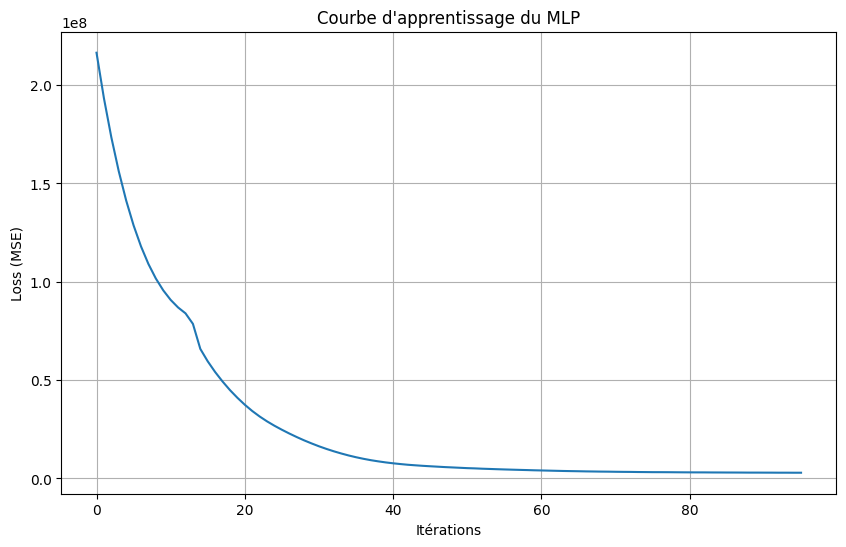


Top 5 des combinaisons d'hyperparamètres:


param_hidden_layer_sizes param_activation  param_alpha  mean_test_score  \
1616                   (100,)         logistic        0.001     -1974.240391   
1618                   (100,)         logistic        0.001     -1974.240391   
1598                   (100,)         logistic        0.001     -1974.240391   
1600                   (100,)         logistic        0.001     -1974.240391   
1582                   (100,)         logistic        0.001     -1974.240391   

      rank_test_score  
1616                1  
1618                1  
1598                1  
1600                1  
1582                1

In [12]:
# Importations nécessaires
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filtrer les warnings de convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Initialisation du modèle
mlp_model = MLPRegressor(random_state=42, early_stopping=True)

# 2. Définition de la grille d'hyperparamètres (simplifiée pour l'exemple)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],  # Terme de régularisation L2
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [100, 200, 300]
}

# 3. Configuration de la recherche par validation croisée
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Métrique d'optimisation
    n_jobs=-1,                  # Utilisation de tous les cœurs CPU
    verbose=1,                  # Affichage détaillé
    return_train_score=True     # Pour analyser les résultats
)

# 4. Recherche des meilleurs hyperparamètres (sur toutes les données)
print("=== Optimisation du MLPRegressor ===")
print("Début de la recherche des hyperparamètres...")
grid_search.fit(X, y)  # Utilisation de X et y complets

# 5. Meilleurs paramètres et modèle
print("\nMeilleurs hyperparamètres trouvés:")
print(grid_search.best_params_)

best_mlp = grid_search.best_estimator_

# 6. Évaluation complète par validation croisée
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error'
}

cv_results = cross_validate(
    best_mlp, 
    X, 
    y, 
    cv=5,
    scoring=scoring,
    return_train_score=True,
    return_estimator=True
)

# 7. Affichage des résultats
print("\n=== Performances moyennes ===")
print(f"R² (validation): {np.mean(cv_results['test_r2']):.4f}")
print(f"MAE (validation): {-np.mean(cv_results['test_mae']):.2f} DH")
print(f"RMSE (validation): {-np.mean(cv_results['test_rmse']):.2f} DH")

print("\n=== Analyse de surajustement ===")
print(f"Différence R² train/validation: {np.mean(cv_results['train_r2']) - np.mean(cv_results['test_r2']):.4f}")

# 8. Visualisation de la courbe d'apprentissage du meilleur modèle
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_)
plt.title("Courbe d'apprentissage du MLP")
plt.xlabel("Itérations")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

# 9. Analyse des résultats de la grid search
results = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 des combinaisons d'hyperparamètres:")
display(results.sort_values(by='rank_test_score').head(5)[[
    'param_hidden_layer_sizes',
    'param_activation',
    'param_alpha',
    'mean_test_score',
    'rank_test_score'
]])